<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Expected-Return-on-a-Shot-Attempt-and-Field-Goal-Percentages" data-toc-modified-id="Expected-Return-on-a-Shot-Attempt-and-Field-Goal-Percentages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Expected Return on a Shot Attempt and Field Goal Percentages</a></span></li><li><span><a href="#Example-shot-charts" data-toc-modified-id="Example-shot-charts-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example shot charts</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Regression</a></span><ul class="toc-item"><li><span><a href="#For-coefficient-interpretation" data-toc-modified-id="For-coefficient-interpretation-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>For coefficient interpretation</a></span></li></ul></li><li><span><a href="#Bayes-Distributions" data-toc-modified-id="Bayes-Distributions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Bayes Distributions</a></span><ul class="toc-item"><li><span><a href="#Focus-on-2-Players-from-2-Up-and-Coming-Teams" data-toc-modified-id="Focus-on-2-Players-from-2-Up-and-Coming-Teams-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Focus on 2 Players from 2 Up and Coming Teams</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [142]:
from nba_api.stats.endpoints import shotchartdetail
import json
import requests

In [212]:
df = pd.read_csv('../data/clustered_players.csv')
df_bt = pd.read_csv('../data/boxscore_traditional.csv')
df_bs = pd.read_csv('../data/boxscore_scoring.csv')

# EDA

## Expected Return on a Shot Attempt and Field Goal Percentages

In [75]:
names = df[['PLAYER_NAME', 'FG3_PCT', 'FG_PCT']].sample(3)
names['expected_pts_per_3_att'] = names['FG3_PCT']*3
names['percent_2_att_equiv'] = names['expected_pts_per_3_att']/2

In [76]:
names

,PLAYER_NAME,FG3_PCT,FG_PCT,expected_pts_per_3_att,percent_2_att_equiv
197,Jalen Smith,0.200000,0.416800,0.60000,0.300000
104,DeMarcus Cousins,0.300083,0.352833,0.90025,0.450125
236,Josh Hart,0.353667,0.452233,1.06100,0.530500


<Figure size 1296x720 with 0 Axes>

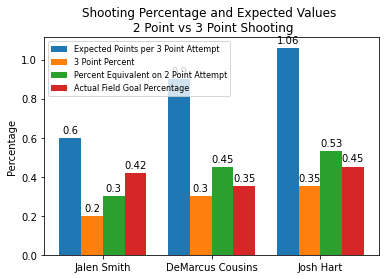

In [135]:
labels = names['PLAYER_NAME']
fg3_pct = names['FG3_PCT']
exp_per_3_att = names['expected_pts_per_3_att']
perc_2_equiv = names['percent_2_att_equiv']
fg_pct = names['FG_PCT']

plt.figure(figsize=(18,10))
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, exp_per_3_att, width, label='Expected Points per 3 Point Attempt')
rects2 = ax.bar(x - width*0.5, fg3_pct, width, label='3 Point Percent')
rects3 = ax.bar(x + width*0.5, perc_2_equiv, width, label='Percent Equivalent on 2 Point Attempt')
rects4 = ax.bar(x + width*1.5, fg_pct, width, label='Actual Field Goal Percentage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Shooting Percentage and Expected Values \n 2 Point vs 3 Point Shooting')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left',fontsize=8)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

# fig.tight_layout()

plt.show()

In general players shoot well enough from 3-point range that only shooting close to the basket is "worth it" according to the expected return points of a shot attempt.

The blue bar shows the expected return of a 3-point shot attempt for that player. The orange bar is the player's actual 3-point shooting percentage, red is their actual overall shooting percentage, and the green bar is the shooting percentage that a player would need to shoot in order to have the same expected return on a 2-point shot that they currently have on a 3-point attempt.

## Example shot charts

There are several players that came into the NBA playing a more traditional style and whos styly of play has evolved to match today's trends. Blake Griffin is one example of a player that took many midrange 2 point attempts as a star on the Clippers but in the current season primarily took either shot attempts at the rim or from 3-poin range.

Scraping and setting up the shot chart data for Blake Griffin's 2015-2016 Season and the current 2020-2021 season into dataframes:

In [145]:
#https://github.com/danchyy/Basketball_Analytics/blob/master/Scripts/2018_19_season/brook_lopez_evolution/brook_lopez.ipynb
#https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d

players = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/players.json').text)


def get_player_id(first, last):
    for player in players:
        if player['firstName'] == first and player['lastName'] == last:
            return player['playerId']
    return -1

teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)

def get_team_id(team_name):
    for team in teams:
        if team['teamName'] == team_name:
            return team['teamId']
    return -1

shot_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id('Detroit Pistons'),
            player_id = get_player_id('Blake', 'Griffin'),
            context_measure_simple = 'PTS',
            season_nullable = '2020-21',
            season_type_all_star = 'Regular Season')

shot_data = json.loads(shot_json.get_json())

relevant_data = shot_data['resultSets'][0]
headers = relevant_data['headers']
rows = relevant_data['rowSet']

# Create pandas DataFrame
griffin_2021_data = pd.DataFrame(rows)
griffin_2021_data.columns = headers

shot_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id('Los Angeles Clippers'),
            player_id = get_player_id('Blake', 'Griffin'),
            context_measure_simple = 'PTS',
            season_nullable = '2015-16',
            season_type_all_star = 'Regular Season')

shot_data = json.loads(shot_json.get_json())

relevant_data = shot_data['resultSets'][0]
headers = relevant_data['headers']
rows = relevant_data['rowSet']

# Create pandas DataFrame
griffin_1516_data = pd.DataFrame(rows)
griffin_1516_data.columns = headers

Setting up the background court image:

In [168]:
from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib as mpl
#https://www.jphwang.com/nba-shot-data-analytics-visualization-with-python-pandas-and-matplotlib-part-2-grouping-data-by-area/
# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    return ax

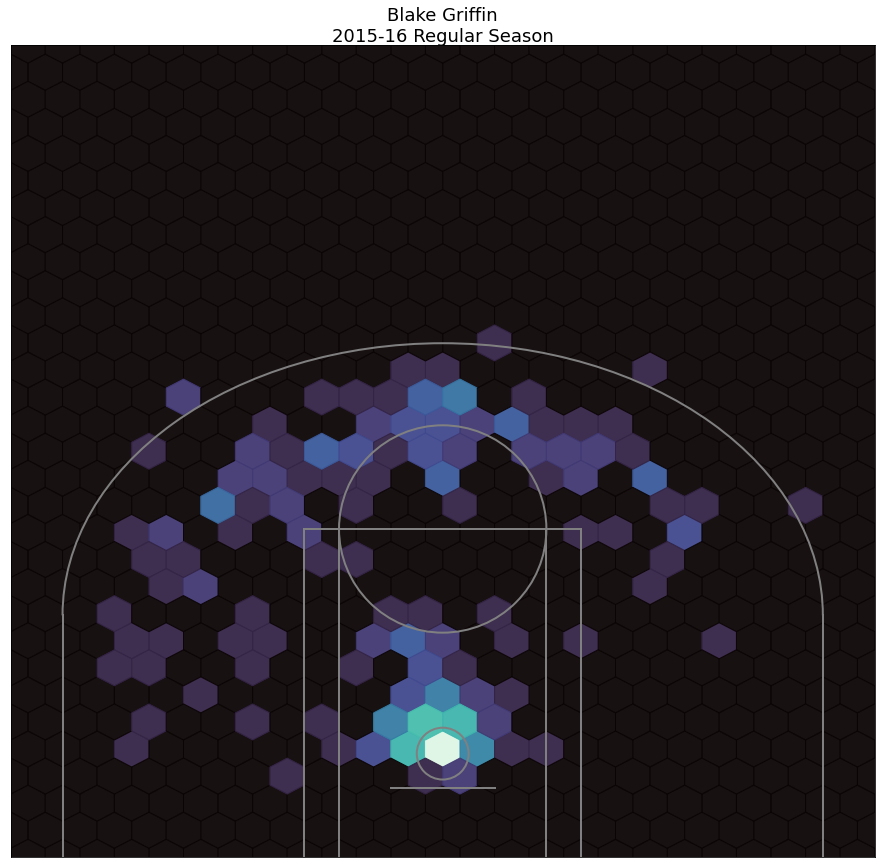

In [211]:
fig = plt.figure(figsize=(4*3, 3.76*3))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'grey')

# Plot hexbin of shots
ax.hexbin(griffin_1516_data['LOC_X'], griffin_1516_data['LOC_Y'] + 60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='mako', alpha=.95)

# Annotate player name and season
plt.title('Blake Griffin\n2015-16 Regular Season', transform=ax.transAxes, ha='center', fontsize=18, pad=15)

# Save and show figure
plt.savefig('../images/bgriffin_1516.png', dpi=300, bbox_inches='tight')
plt.show()

In the 2015-2016 season Blake Griffin took mainly 2-point shot attempts, either close to the basket or from midrange.

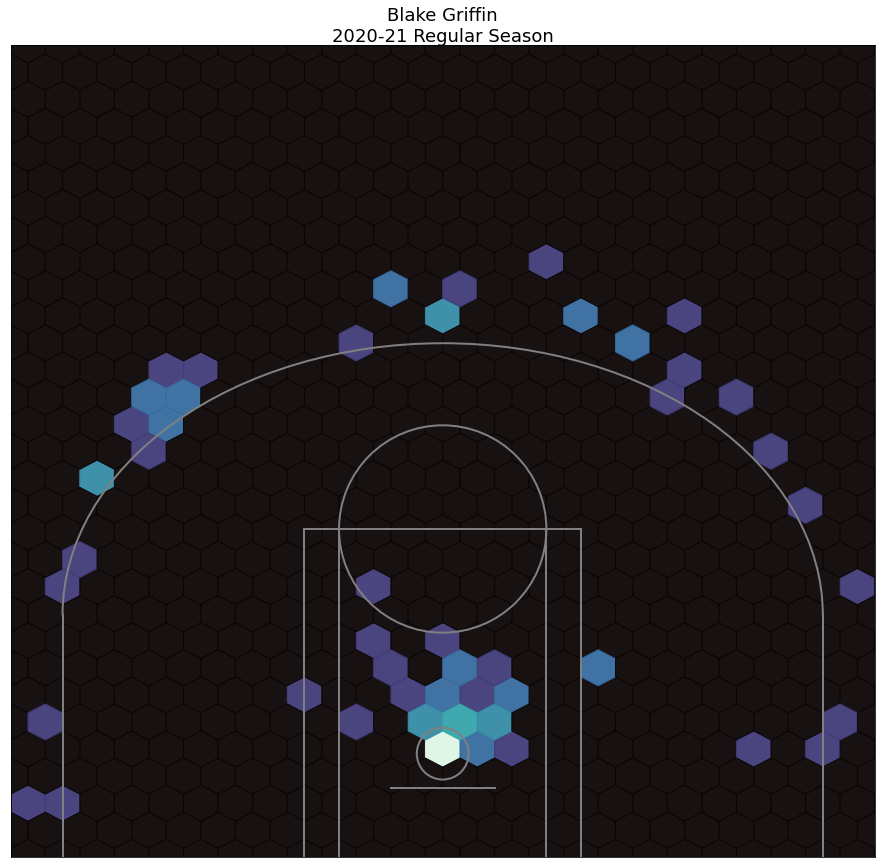

In [210]:
fig = plt.figure(figsize=(4*3, 3.76*3))
ax = fig.add_axes([0, 0, 1, 1])

# Draw court
ax = create_court(ax, 'grey')

# Plot hexbin of shots
ax.hexbin(griffin_2021_data['LOC_X'], griffin_2021_data['LOC_Y'] + 60, gridsize=(30, 30), extent=(-300, 300, 0, 940), bins='log', cmap='mako', alpha=.95)

# Annotate player name and season
plt.title('Blake Griffin\n2020-21 Regular Season', transform=ax.transAxes, ha='center', fontsize=18, pad=15)

# Save and show figure
plt.savefig('../images/bgriffin_2021.png', dpi=300, bbox_inches='tight')
plt.show()

In the current 2020-2021 season Blake Griffin took mainly 2-point shot attempts close to the basket or from 3-point range.

## Regression

### For coefficient interpretation

## Bayes Distributions

### Focus on 2 Players from 2 Up and Coming Teams

In [223]:
df_kp = df_bs[df_bs['PLAYER_NAME'] == 'Kristaps Porzingis']
df_ld = df_bs[df_bs['PLAYER_NAME'] == 'Luka Doncic']
df_jr = df_bs[df_bs['PLAYER_NAME'] == 'Julius Randle']
df_rjb = df_bs[df_bs['PLAYER_NAME'] == 'RJ Barrett']